In [16]:
import tensorflow as tf
#print(tf.__version__)
import tensorflow_datasets as tfds
#print(tfds.__version__)

import numpy as np
import os 
import random
import zipfile 
from pathlib import Path

#import tensorflow as tf 


import matplotlib.pyplot as plt
# Tensorflow tools
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)

import keras.preprocessing
from tensorflow.keras.utils import plot_model 
from tensorflow.keras import backend as K

# Image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array)
import cv2


# Optimizers
from tensorflow.keras.optimizers import SGD, Adam 





In [2]:
#from utils import pre_trained_utils as pre_tils

In [3]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
training_data = tf.keras.preprocessing.image_dataset_from_directory( # loading data, making them categorical, defining seed, shape and batch sizes.
    os.path.join("..", "..", "data", "4", "architectural-styles-dataset"), # The function image_dataset_from_directory needs a directory of where the data is located. When it has this, it can 'infer' the labels from the subdirectories, because each of the subdirectories contain the name of the class they include.
    label_mode = 'categorical', #'categorical' means that the labels are encoded as a categorical vector - one-hot encoding
    seed=2021,
    shuffle = False, # now data is in alphanumeric order.
    validation_split = 0.20,
    subset = "training",
    image_size=(224, 224))

validation_data = tf.keras.preprocessing.image_dataset_from_directory( # loading data, making them categorical, defining seed, shape and batch sizes.
    os.path.join("..", "..", "data", "4", "architectural-styles-dataset"), # The function image_dataset_from_directory needs a directory of where the data is located. When it has this, it can 'infer' the labels from the subdirectories, because each of the subdirectories contain the name of the class they include.
    label_mode = 'categorical', #'categorical' means that the labels are encoded as a categorical vector - one-hot encoding
    seed=2021,
    shuffle = False, # Now data is in alphanumeric order.
    validation_split = 0.20,
    subset = "validation",
    image_size=(224, 224))



Found 10113 files belonging to 25 classes.
Using 8091 files for training.
Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


In [5]:
class_names = training_data.class_names

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # Defining normalization layer       
training_data = training_data.map(lambda x, y: (normalization_layer(x), y)) # Applying the above defined layer
training_data = validation_data.map(lambda x, y: (normalization_layer(x), y)) # Applying the above defined layer


In [40]:
def process(image, label):
    '''
    Function that normalizes all images in training and testing datasets
    '''
    image = tf.cast(image/255. ,tf.float32)
    return image, label

In [41]:
training_data = training_data.map(process)
validation_data = validation_data.map(process)

In [82]:
y_val = np.concatenate([y for x, y in validation_data], axis=0)

In [91]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
#_, labels_batch_train = next(iter(training_data))
#_, labels_batch_val = next(iter(validation_data))

In [17]:
def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    if tf.__version__[0] == '2':
        tf.random.set_seed(3)
    else:
        tf.set_random_seed(3)
    print("RANDOM SEEDS RESET")
    
reset_seeds()
del model2
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()


RANDOM SEEDS RESET


In [18]:
tf.keras.backend.clear_session()

In [8]:
model2 = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    pooling = 'avg',
    classes = 25,
    include_top=False)

# Pooling options:
   # None means that the output of the model will be the 4D tensor output of the last convolutional layer.
   # avg means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.
   # max means that global max pooling will be applied.

In [9]:
for layer in model2.layers: # Running through every layer of the model 
    layer.trainable = False # Setting the option to train the layers again to false

In [10]:
model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
from contextlib import redirect_stdout

num_classes = 25

# add new classifier layers
flat1 = Flatten()(model2.layers[-1].output) #the return value of Flatten() is a function apparently - Reverse index - very confusing syntax
class1 = Dense(256, 
               activation='relu')(flat1)
output = Dense(num_classes, 
               activation='softmax')(class1)

# define new model
model2 = Model(inputs=model2.inputs, # inputs 
              outputs=output) # outputs
# summarize
model2.summary()

#with open('modelsummary.txt', 'w') as f:
#    with redirect_stdout(f):
#        model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
# Compiling model
# We compile using ADAM and categorical cross-entropy as the loss function.
model2.compile(optimizer=Adam(learning_rate = 0.00001), # was 0.0001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
epochs = 10
H = model2.fit(
  training_data,
  validation_data=(validation_data), # Data on which to evaluate the loss at the end of each epoch - model will not be trained on this data. 
  batch_size=128,
  epochs=epochs)

Epoch 1/10
64/64 [==============================] - 383s 6s/step - loss: 2.9778 - accuracy: 0.0000e+00 - val_loss: 3.1606 - val_accuracy: 0.1528
Epoch 2/10
64/64 [==============================] - 440s 7s/step - loss: 2.6385 - accuracy: 0.4839 - val_loss: 2.9347 - val_accuracy: 0.2191
Epoch 3/10
64/64 [==============================] - 399s 6s/step - loss: 2.4058 - accuracy: 0.4889 - val_loss: 2.7561 - val_accuracy: 0.2636
Epoch 4/10
64/64 [==============================] - 520s 8s/step - loss: 2.2322 - accuracy: 0.4889 - val_loss: 2.6170 - val_accuracy: 0.2908
Epoch 5/10
64/64 [==============================] - 427s 7s/step - loss: 2.1116 - accuracy: 0.4889 - val_loss: 2.5093 - val_accuracy: 0.3051
Epoch 6/10
64/64 [==============================] - 457s 7s/step - loss: 2.0292 - accuracy: 0.4889 - val_loss: 2.4248 - val_accuracy: 0.3106
Epoch 7/10
64/64 [==============================] - 312s 5s/step - loss: 1.9722 - accuracy: 0.4889 - val_loss: 2.3580 - val_accuracy: 0.3145
Epoch 8/1

In [15]:
# Saving the model 
model_name = "architecture_model"
model.save(model_name)

INFO:tensorflow:Assets written to: architecture_model/assets


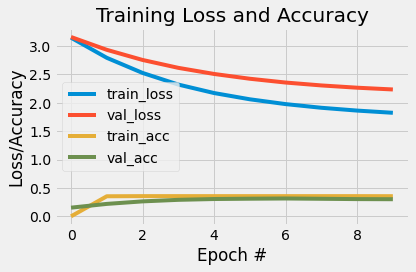

In [14]:
import numpy as np
plot_history(H, 10)

In [4]:
from tensorflow import keras
model = keras.models.load_model('architecture_model')

In [9]:
# Predict unseen image
image = tf.keras.preprocessing.image.load_img(os.path.join("..","..","data","4","unseen-img.jpeg"),
                                             target_size = (224, 224))

# Preprocessing 
x = keras.preprocessing.image.img_to_array(image)/255.
x = np.expand_dims(x, axis=0)

# The images are converted from RGB to BGR
# Each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
# x = tf.keras.applications.resnet.preprocess_input(x)

predictions = model.predict(x)


In [91]:
y_val = np.concatenate([y for x, y in validation_data], axis=0)
x_val = np.concatenate([x for x, y in validation_data], axis=0)

In [92]:
predictions_all = model.predict(x_val)

In [105]:
from sklearn.metrics import (classification_report, confusion_matrix)

report = classification_report(y_val.argmax(axis=1), # y true - .argmax(axis=1) to retrieve actual labels
                     predictions_all.argmax(axis=1), # y pred .argmax(axis=1) to retrieve actual labels
                     target_names=class_names, # labels defined in the first function
                     output_dict=True)

confusion_matrix = confusion_matrix(y_val.argmax(axis=1), predictions_all.argmax(axis=1))


2022
2022


In [6]:
# Convert the probabilities to class labels
preds_w_names = list(zip(class_names, predictions[0]))
print(preds_w_names)

[('Achaemenid architecture', 0.047307324), ('American Foursquare architecture', 0.034013405), ('American craftsman style', 0.020759875), ('Ancient Egyptian architecture', 0.022388803), ('Art Deco architecture', 0.018214207), ('Art Nouveau architecture', 0.01610528), ('Baroque architecture', 0.037834104), ('Bauhaus architecture', 0.015919559), ('Beaux-Arts architecture', 0.04862472), ('Byzantine architecture', 0.051603924), ('Chicago school architecture', 0.060078945), ('Colonial architecture', 0.057021525), ('Deconstructivism', 0.018525751), ('Edwardian architecture', 0.02651906), ('Georgian architecture', 0.028223187), ('Gothic architecture', 0.02933882), ('Greek Revival architecture', 0.06658423), ('International style', 0.14164211), ('Novelty architecture', 0.046875153), ('Palladian architecture', 0.057010885), ('Postmodern architecture', 0.043225084), ('Queen Anne architecture', 0.018166529), ('Romanesque architecture', 0.03828838), ('Russian Revival architecture', 0.030990915), ('

/home/cds-au604011/cds-visual/cv101/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


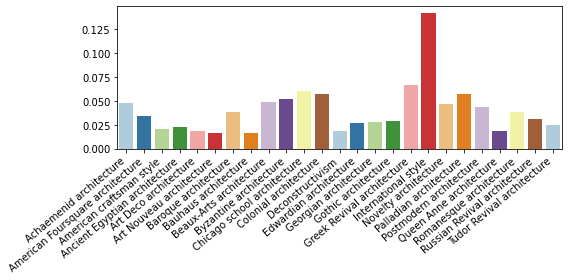

In [11]:
import seaborn as sns
palette = sns.color_palette("Paired")
plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high
bplot = sns.barplot(class_names, predictions[0], palette = palette)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.savefig(os.path.join("..","..","out","4", f'probabilities_new_building.png')) # Specifying save location and name
plt.show()

In [106]:
# Grad CAM - fancy way of saying that we are taking advantage of the way the model learns gradients - uses gradients from network to figure out how to modify

# Take one picture from each class and print the 'heatmaps'
with tf.GradientTape() as tape:
    
    # make sure the name here corresponds to the final conv layer in your network
    last_conv_layer = model.get_layer('conv5_block3_out') # Last convolutional layer
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions    
    iterate = tf.keras.models.Model([model.inputs], 
                                    [model.output, last_conv_layer.output])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    model_out, last_conv_layer = iterate(x) # Collecting the gradients of the model
    class_out = model_out[:, np.argmax(model_out[0])]
    
    # This is the gradient of the output neuron of the last conv layer
    grads = tape.gradient(class_out, 
                          last_conv_layer)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2)) # Just like in numpy, you can define the axis along you want to perform a certain operation


In [107]:
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation

# Show regions with informative pixesls
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), 
                         axis=-1)

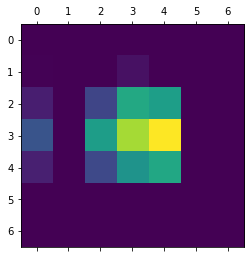

In [108]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((7, 7))
plt.matshow(heatmap)
plt.show()

In [110]:
import cv2

# Load the original image
img = cv2.imread("architectural-styles-dataset/American Foursquare architecture/001320.jpg")
# heatmap should be semi transparent
intensity = 0.5

# resize the heatmap to be the original dimensions of the input 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# multiply heatmap by intensity and 'add' this on top of the original image
superimposed = (heatmap * intensity) + img

In [114]:
style = "American Foursquare architecture"
cv2.imwrite(os.path.join("heatmaps", f"super_im_{style.replace(' ', '_')}.jpg"), superimposed)

True

In [34]:
import os, random
random.seed(8000)
# list all files in dir
heatmaps = []
path = os.path.join("..", "..", "data", "4", "architectural-styles-dataset")
styles = os.listdir(os.path.join("..", "..", "data", "4", "architectural-styles-dataset"))

for subfolder in sorted(styles):
    pics = os.listdir(os.path.join(f"{path}",f"{subfolder}"))
    
    random_pic = random.choice(pics)
    
    random_pic_path = os.path.join(f"{path}",f"{subfolder}", f"{random_pic}")
    image = tf.keras.preprocessing.image.load_img(random_pic_path, target_size = (224, 224))

    # Preprocessing 
    x = keras.preprocessing.image.img_to_array(image)/255.
    x = np.expand_dims(x, axis=0)
    
    predictions = model.predict(x)

    print("[INFO] Performing GradientTape")
    with tf.GradientTape() as tape:

        # make sure the name here corresponds to the final conv layer in your network
        last_conv_layer = model.get_layer('conv5_block3_out') # Last convolutional layer

        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions    
        iterate = tf.keras.models.Model([model.inputs], 
                                        [model.output, last_conv_layer.output])

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        model_out, last_conv_layer = iterate(x) # Collecting the gradients of the model
        class_out = model_out[:, np.argmax(model_out[0])]

        # This is the gradient of the output neuron of the last conv layer
        grads = tape.gradient(class_out, 
                              last_conv_layer)

        # Vector of mean intensity of the gradient over a specific feature map channel
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # Just like in numpy, you can define the axis along you want to perform a certain operation

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), 
                     axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))
    
    # Load the original image
    original = cv2.imread(str(random_pic_path))
    
    # heatmap should be semi transparent
    intensity = 0.5
    
    # resize the heatmap to be the original dimensions of the input 
    heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

    
    # https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    # multiply heatmap by intensity and 'add' this on top of the original image
    superimposed = (heatmap * intensity) + original
    #superimposed_224 = cv2.resize(superimposed, (224,224))
    #superimposed_224 = cv2.cvtColor(np.float32(superimposed_224), cv2.COLOR_BGR2RGB)


    heatmaps.append(superimposed)
    #cv2.imwrite(os.path.join("heatmaps", f"super_im_{subfolder.replace(' ', '_')}.jpg"), superimposed)    
    #print(f"[INFO] Super imposed image saved as super_im_{subfolder.replace(' ', '_')}.jpg")

    

[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape
[INFO] Performing GradientTape


In [25]:
heatmaps

[array([[[356. , 331.5, 136. ],
         [357. , 332.5, 137. ],
         [358. , 333.5, 138. ],
         ...,
         [359. , 201. , 108. ],
         [359. , 201. , 108. ],
         [359. , 201. , 108. ]],
 
        [[356. , 331.5, 136. ],
         [357. , 332.5, 137. ],
         [358. , 333.5, 138. ],
         ...,
         [359. , 201. , 108. ],
         [359. , 201. , 108. ],
         [359. , 201. , 108. ]],
 
        [[357. , 332.5, 137. ],
         [357. , 332.5, 137. ],
         [358. , 333.5, 138. ],
         ...,
         [359. , 201. , 108. ],
         [359. , 201. , 108. ],
         [359. , 201. , 108. ]],
 
        ...,
 
        [[126. ,  40. ,  46. ],
         [126. ,  42. ,  48. ],
         [130. ,  44. ,  50. ],
         ...,
         [224.5, 133. , 164. ],
         [221.5, 130. , 161. ],
         [233.5, 142. , 173. ]],
 
        [[122. ,  37. ,  46. ],
         [123. ,  38. ,  47. ],
         [125. ,  40. ,  49. ],
         ...,
         [233.5, 142. , 173. ],
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

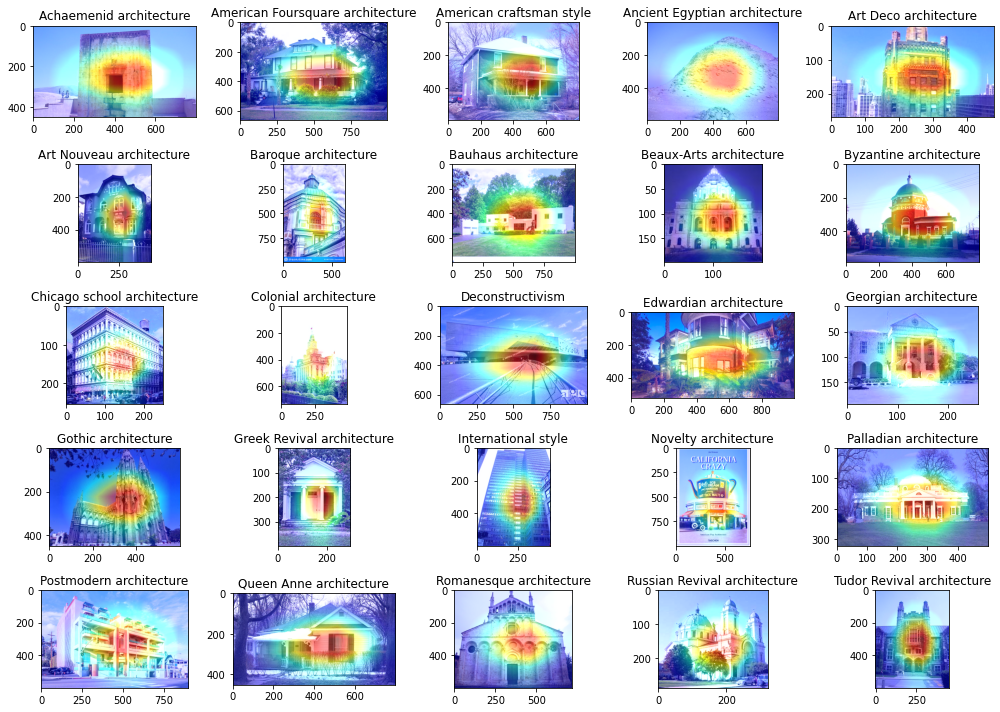

In [33]:
# Plotting all
#sorted_styles = sorted(styles)

import numpy as np
import matplotlib.pyplot as plt

w=224
h=224
fig=plt.figure(figsize=(14, 10))
columns = 5
rows = 5

for i in range(1, columns*rows +1): # Loop running 25 times
    img = heatmaps[i-1] # Take the i-1th image in the list heatmap
    ax = fig.add_subplot(rows, columns, i) # Creating subplot
    ax.set_title(class_names[i-1])# plt.imshow((img*255).astype(np.uint8)) # Changing pixelvalues
    plt.axis('off')
    plt.imshow(img.astype(int)[:,:,::-1]) # Changing pixelvalues to RGB instead of BGR
plt.tight_layout()
plt.show()